Adapted from https://github.com/deepchem/moleculenet/tree/master/examples

and https://github.com/XinhaoLi74/MolPMoFiT


Best performing is:

Best val roc_auc: 0.9713 +- 0.0013

Test roc_auc: 0.7194 +- 0.0068

(*according to https://github.com/deepchem/moleculenet board)

In [ ]:
!pip install deepchem

In [ ]:
import deepchem as dc
from rdkit import Chem
import json
import numpy as np

from copy import deepcopy
from functools import partial
from hyperopt import hp, fmin, tpe
from shutil import copyfile
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import pandas as pd
import errno
import os
import torch
import tensorflow as tf

In [ ]:
from sklearn.metrics import roc_auc_score
import threading

In [ ]:
data = pd.read_csv('BBBP.csv')[['smiles', 'p_np']]
data

,smiles,p_np
0,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,1
1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1
2,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,1
3,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,1
4,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,1
...,...,...
2045,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl,1
2046,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...,1
2047,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...,1
2048,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...,1


In [ ]:
data.p_np.value_counts()

1    1567
0     483
Name: p_np, dtype: int64

The data is unbalanced

In [ ]:
"""
Blood-Brain Barrier Penetration dataset loader.
"""
from deepchem.molnet.load_function.molnet_loader import TransformerGenerator, _MolnetLoader
from deepchem.data import Dataset
from typing import List, Optional, Tuple, Union

BBBP_URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"
BBBP_TASKS = ["p_np"]


class _BBBPLoader(_MolnetLoader):

  def create_dataset(self) -> Dataset:
    dataset_file = os.path.join(self.data_dir, "BBBP.csv")
    if not os.path.exists(dataset_file):
      dc.utils.data_utils.download_url(url=BBBP_URL, dest_dir=self.data_dir)
    loader = dc.data.CSVLoader(
        tasks=self.tasks, feature_field="smiles", featurizer=self.featurizer)
    return loader.create_dataset(dataset_file, shard_size=8192)


def load_bbbp(
    featurizer: Union[dc.feat.Featurizer, str] = 'ECFP',
    splitter: Union[dc.splits.Splitter, str, None] = 'scaffold',
    transformers: List[Union[TransformerGenerator, str]] = ['balancing'],
    reload: bool = True,
    data_dir: Optional[str] = None,
    save_dir: Optional[str] = None,
    **kwargs
) -> Tuple[List[str], Tuple[Dataset, ...], List[dc.trans.Transformer]]:
  loader = _BBBPLoader(featurizer, splitter, transformers, BBBP_TASKS, data_dir,
                       save_dir, **kwargs)
  return loader.load_dataset('bbbp', reload)

In [ ]:
tasks, all_dataset, transformers = load_bbbp(featurizer='ECFP', splitter='scaffold', reload=False)

Failed to featurize datapoint 59, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 61, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 391, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 614, None. Appending empty array
Exception messa

## In this case we use:

- Scaffold splitting (in order to prevent leakage)
- ECFP fingerprints

In [ ]:
all_dataset

(<DiskDataset X.shape: (1631, 1024), y.shape: (1631, 1), w.shape: (1631, 1), task_names: ['p_np']>,
 <DiskDataset X.shape: (204, 1024), y.shape: (204, 1), w.shape: (204, 1), ids: ['[H+].C2=C1C(OC(=NC1=CC=C2Cl)NCC)(C3=CC=CC=C3)C.[Cl-]'
  'C1=CC=CC2=C1C(C3=C(N(C)C2=O)C=CC=C3)OCC'
  'C1=C(Cl)C=CC3=C1C(C2=CC=CC=C2)SC(=N3)NCC' ...
  'CC1(C)S[C@@H]2[C@H](NC(=O)C34C[C@H]5C[C@H](CC(N)(C5)C3)C4)C(=O)N2[C@H]1C(O)=O'
  'COc1cccc2C(=O)c3c(O)c4CC(O)(CC(O)c4c(O)c3C(=O)c12)C(=O)CO'
  'CC[C@@]1(O)C[C@H](OC2CC(C(OC3CC(O)C(OC4CCC(=O)C(C)O4)C(C)O3)C(C)O2)N(C)C)c5c(O)c6C(=O)c7c(O)cccc7C(=O)c6cc5[C@H]1C(=O)OC'], task_names: ['p_np']>,
 <DiskDataset X.shape: (204, 1024), y.shape: (204, 1), w.shape: (204, 1), ids: ['CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N2CCC[C@H]2C(O)=O'
  'FC(F)(F)[C@]1(OC(=O)Nc2ccc(Cl)cc12)C#CC3CC3'
  'CN1C[C@@H](C[C@H]2[C@H]1Cc3c[nH]c4cccc2c34)C(=O)N[C@]5(C)O[C@@]6(O)[C@@H]7CCCN7C(=O)[C@H](Cc8ccccc8)N6C5=O'
  ... 'Cn1c2CCC(Cn3ccnc3C)C(=O)c2c4ccccc14'
  'CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)

In [ ]:
train_df = pd.DataFrame({'smiles': all_dataset[0].ids, 'p_np': [item for sublist in all_dataset[0].y.tolist() for item in sublist]} , columns=["smiles", 'p_np'])
valid_df = pd.DataFrame({'smiles': all_dataset[1].ids, 'p_np': [item for sublist in all_dataset[1].y.tolist() for item in sublist]} , columns=["smiles", 'p_np'])
test_df = pd.DataFrame({'smiles': all_dataset[2].ids, 'p_np': [item for sublist in all_dataset[2].y.tolist() for item in sublist]} , columns=["smiles", 'p_np'])
train_df.to_csv("train.csv")
valid_df.to_csv("valid.csv")
test_df.to_csv("test.csv")

# Add data augmentation

In [ ]:
def augmentation(df, n_rounds):
    dist_aug = {col_name: [] for col_name in df}

    for i in range(df.shape[0]):
        if df.iloc[i].p_np == 1:
            for j in range(n_rounds[0]):
              try:
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])
              except:
                print(df.iloc[i].smiles)

        if df.iloc[i].p_np == 0:
            for j in range(n_rounds[1]):
              try:
                dist_aug['smiles'].append(randomize_smiles(df.iloc[i].smiles))
                dist_aug['p_np'].append(df.iloc[i]['p_np'])
              except:
                print(df.iloc[i].smiles)
        
    df_aug = pd.DataFrame.from_dict(dist_aug)
    df_aug = df_aug.append(df, ignore_index=True)
    return df_aug.drop_duplicates('smiles')

In [ ]:
print(train_df.p_np.value_counts())
print(valid_df.p_np.value_counts())

1.0    1341
0.0     290
Name: p_np, dtype: int64
1.0    112
0.0     92
Name: p_np, dtype: int64


In [ ]:
def randomize_smiles(smiles):
    m = Chem.MolFromSmiles(smiles)
    ans = list(range(m.GetNumAtoms()))
    np.random.shuffle(ans)
    nm = Chem.RenumberAtoms(m,ans)
    return Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True, kekuleSmiles=False)


In [ ]:
train_aug = augmentation(train_df, [10,50])

print('Train_aug Samples:', train_aug.shape[0])
print('Positive:Negative',np.sum(train_aug.p_np == 1)/ np.sum(train_aug.p_np == 0))

Train_aug Samples: 27057
Positive:Negative 1.0348198841844025


This tries to solve class imbalance problem

In [ ]:
train_aug.to_csv('aug.csv', index=False)

# Random Forest model with bayesian hyperparameters search

In [ ]:
dataset_file = os.path.join('/content/', 'aug.csv')
loader = dc.data.CSVLoader(tasks=['p_np'], feature_field="smiles", featurizer= dc.feat.CircularFingerprint(size=1024))
dt = loader.create_dataset(dataset_file, shard_size=8192)

In [ ]:
dt

<DiskDataset X.shape: (27057, 1024), y.shape: (27057, 1), w.shape: (27057, 1), task_names: ['p_np']>

In [ ]:
def rf_model_builder(model_dir, hyperparams, mode):
  if mode == 'classification':
    sklearn_model = RandomForestClassifier(
        n_estimators=hyperparams['n_estimators'],
        criterion=hyperparams['criterion'],
        min_samples_split=hyperparams['min_samples_split'],
        bootstrap=hyperparams['bootstrap'])
  return dc.models.SklearnModel(sklearn_model, model_dir)


def load_model(args, tasks, hyperparams):
  
  mode = 'classification'

  model = dc.models.SingletaskToMultitask(tasks, partial(rf_model_builder, hyperparams=hyperparams, mode=mode))

  return model


def main(train_set, val_set, test_set, save_path, args, hyperparams):
  # Dataset
  #args, tasks, all_dataset, transformers = load_dataset(args)
  #train_set, val_set, test_set = all_dataset


  # Metric
  if args['metric'] == 'roc_auc':
    metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
  
  all_run_val_metrics = []
  all_run_test_metrics = []

  for _ in range(args['num_runs']):
    # Model
    model = load_model(args, tasks, hyperparams)
    model.fit(train_set)

    val_metric = model.evaluate(val_set, [metric], transformers)
    test_metric = model.evaluate(test_set, [metric], transformers)

    if args['metric'] == 'roc_auc':
      val_metric = val_metric['mean-roc_auc_score']
      test_metric = test_metric['mean-roc_auc_score']

    all_run_val_metrics.append(val_metric)
    all_run_test_metrics.append(test_metric)

  with open(save_path + '/eval.txt', 'w') as f:
    f.write('Best val {}: {:.4f} +- {:.4f}\n'.format(
        args['metric'], np.mean(all_run_val_metrics),
        np.std(all_run_val_metrics)))
    f.write('Test {}: {:.4f} +- {:.4f}\n'.format(args['metric'],
                                                 np.mean(all_run_test_metrics),
                                                 np.std(all_run_test_metrics)))

  with open(save_path + '/configure.json', 'w') as f:
    json.dump(hyperparams, f, indent=2)

  return all_run_val_metrics, all_run_test_metrics


def init_hyper_search_space(args):
  # Model-based search space
  if args['model'] == 'RF':
    search_space = {
        'n_estimators': hp.choice('n_estimators', [10, 30, 100]),
        'min_samples_split': hp.choice('min_samples_split', [2, 4, 8, 16, 32]),
        'bootstrap': hp.choice('bootstrap', [True, False]),
    }
    search_space['criterion'] = hp.choice('criterion', ["gini", "entropy"])


  return search_space


def bayesian_optimization(args, train_set, val_set, test_set):
  results = []
  candidate_hypers = init_hyper_search_space(args)

  def objective(hyperparams):
    configure = deepcopy(args)
    save_path = init_trial_path(args)
    val_metrics, test_metrics = main(train_set, val_set, test_set, save_path, configure, hyperparams)

    if args['metric'] in ['roc_auc']:
      # To maximize a non-negative value is equivalent to minimize its opposite number
      val_metric_to_minimize = -1 * np.mean(val_metrics)
    else:
      val_metric_to_minimize = np.mean(val_metrics)

    results.append((save_path, val_metric_to_minimize, val_metrics,
                    test_metrics))

    return val_metric_to_minimize

  fmin(
      objective,
      candidate_hypers,
      algo=tpe.suggest,
      max_evals=args['num_trials'])
  results.sort(key=lambda tup: tup[1])
  best_trial_path, _, best_val_metrics, best_test_metrics = results[0]

  copyfile(best_trial_path + '/configure.json',
           args['result_path'] + '/configure.json')
  copyfile(best_trial_path + '/eval.txt', args['result_path'] + '/eval.txt')

  return best_val_metrics, best_test_metrics

In [ ]:
def mkdir_p(path):
  """Create a folder for the given path.
  Parameters
  ----------
  path: str
    Folder to create.
  """
  try:
    os.makedirs(path)
    print('Created directory {}'.format(path))
  except OSError as exc:
    if exc.errno == errno.EEXIST and os.path.isdir(path):
      print('Directory {} already exists.'.format(path))
    else:
      raise


def init_trial_path(args):
  """Initialize the path for a hyperparameter setting
  Parameters
  ----------
  args : dict
    Settings
  Returns
  -------
  args : dict
    Settings with the trial path updated
  """
  trial_id = 0
  path_exists = True
  while path_exists:
    trial_id += 1
    path_to_results = args['result_path'] + '/{:d}'.format(trial_id)
    path_exists = os.path.exists(path_to_results)
  mkdir_p(path_to_results)

  return path_to_results


class EarlyStopper():

  def __init__(self, save_path, metric, patience):
    if metric in ['roc_auc', 'r2']:
      self.best_score = 0
      self.mode = 'higher'
    elif metric in ['rmse']:
      self.best_score = float('inf')
      self.mode = 'lower'
    else:
      raise ValueError('Unexpected metric: {}'.format(metric))

    self.save_path = save_path
    self.max_patience = patience
    self.patience_count = 0

  def __call__(self, model, current_score):
    from deepchem.models import TorchModel
    if self.mode == 'higher' and current_score > self.best_score:
      self.best_score = current_score
      self.patience_count = 0
      if type(model).__bases__[0] == TorchModel:
        torch.save(model.model.state_dict(), self.save_path + '/early_stop.pt')
      else:  # KerasModel
        model.model.save(self.save_path + '/early_stop')
    elif self.mode == 'lower' and current_score < self.best_score:
      self.best_score = current_score
      self.patience_count = 0
      if type(model).__bases__[0] == TorchModel:
        torch.save(model.model.state_dict(), self.save_path + '/early_stop.pt')
      else:  # KerasModel
        model.model.save(self.save_path + '/early_stop')
    else:
      self.patience_count += 1

    return self.patience_count == self.max_patience

  def load_state_dict(self, model):
    model.model.load_state_dict(torch.load(self.save_path + '/early_stop.pt'))

  def load_keras_model(self, model):
    model.restore(model_dir=self.save_path)

In [ ]:
args= {'dataset' : 'BBBP',
  'model' : 'RF',
  'featurizer' : 'ECFP',
  'result_path' : 'results',
  'num_runs' : 3,
  'hyper_search' : True,
  'num_trials' : 16}

  # Decide the metric to use based on the dataset
args['metric'] = 'roc_auc'

mkdir_p(args['result_path'])
train_set = dt 
val_set = all_dataset[1] 
test_set = all_dataset[2] 
if args['hyper_search']:
  print('Start hyperparameter search with Bayesian '
        'optimization for {:d} trials'.format(args['num_trials']))
  val_metrics, test_metrics = bayesian_optimization(args, train_set, val_set, test_set)
else:
  print('Use the manually specified hyperparameters')
  with open('configures/{}_{}/{}.json'.format(
      args['model'], args['featurizer'], args['dataset'])) as f:
    default_hyperparams = json.load(f)
  val_metrics, test_metrics = main(train_set, val_set, test_set, args['result_path'], args,
                                    default_hyperparams)

  print('Val metric for 3 runs: {:.4f} +- {:.4f}'.format(
      np.mean(val_metrics), np.std(val_metrics)))
  print('Test metric for 3 runs: {:.4f} +- {:.4f}'.format(
      np.mean(test_metrics), np.std(test_metrics)))

Directory results already exists.
Start hyperparameter search with Bayesian optimization for 16 trials
Created directory results/6
Created directory results/7
Created directory results/8
Created directory results/9
Created directory results/10
Created directory results/11
Created directory results/12
Created directory results/13
Created directory results/14
Created directory results/15
Created directory results/16
Created directory results/17
Created directory results/18
Created directory results/19
Created directory results/20
Created directory results/21
100%|██████████| 16/16 [06:11<00:00, 23.20s/it, best loss: -0.9697204968944099]


Here we got 

Best val roc_auc: 0.9708 +- 0.0018

Test roc_auc: 0.7277 +- 0.0122

{
  "bootstrap": false,
  "criterion": "entropy",
  "min_samples_split": 4,
  "n_estimators": 100
}

The ROC-AUC metric
is suitable for the BBBP prediction from the point of view of the brain–drug discovery,
because the metric is probabilistic and sensitive to the prediction quality for both the
positive and negative penetration

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
model = RandomForestClassifier(n_estimators=100,
      criterion="entropy",
      min_samples_split = 4,
      bootstrap=False)

In [ ]:
model.fit(train_set.X, train_set.y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(criterion='entropy', min_samples_split=32)

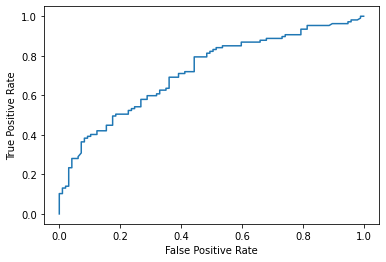

In [ ]:
y_pred_proba = model.predict_proba(test_set.X)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_set.y,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

MoleculeNet recommends to use ROC-AUC and the
fixed scaffold split. The procedure of this split is as follows: (1) the molecular compounds
are grouped into scaffold sets on the basis of the skeletal ring structures termed scaffolds ; (2) the compounds are sorted in reverse order (descending sort), and the scaffold
sets are sorted from the largest to the smallest; (3) the dataset are split into training, validation, and test data in an 8:1:1 ratio from the top. 

In [ ]:
predictions = model.predict(test_set.X)

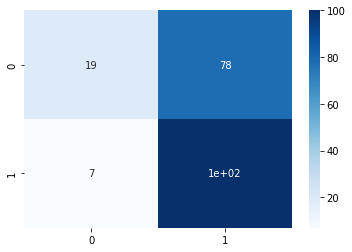

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(test_set.y, predictions), annot=True, cmap="Blues")

Despite rather good ROC AUC score the confusion matrix shows high FP rate. Interestigly, FN rate is really low.

Looking at validation and test scores we can assume that the model tends to overfit. However, this is not really surprising in respect that scaffold split is unbalanced.

## However, ECFP fingerprints are not explainable features. Let's try Lipinski features in order to try to undertable fetures importance



In [ ]:
import rdkit.Chem.Lipinski
import rdkit.Chem.Fragments
import rdkit.Chem.QED

The idea about descriptors is taken from a recent article with minor changes

Sakiyama H, Fukuda M, Okuno T. Prediction of Blood-Brain Barrier Penetration (BBBP) Based on Molecular Descriptors of the Free-Form and In-Blood-Form Datasets. Molecules. 2021;26(24):7428. Published 2021 Dec 7. doi:10.3390/molecules26247428

a group of authors performed a complex analysis and comparison of diffrent approaches of handling BBBP data

In [ ]:
ms = [Chem.MolFromSmiles(i) for i in test_df['smiles'].to_list()]
nh = [Chem.Lipinski.NHOHCount(x) for x in ms] 
het = [Chem.Lipinski.NumHeteroatoms(x) for x in ms] 
don = [Chem.Lipinski.NumHDonors(x) for x in ms]
nhoh = [Chem.Lipinski.NHOHCount(x) for x in ms]
acc = [Chem.Lipinski.NumHAcceptors(x) for x in ms]
sat_het = [Chem.Lipinski.NumSaturatedHeterocycles(x) for x in ms]
ter = [Chem.Fragments.fr_Al_OH_noTert(x) for x in ms]
alip = [Chem.Lipinski.NumAliphaticHeterocycles(x) for x in ms]
no = [Chem.Lipinski.NOCount(x) for x in ms]
qed = [Chem.QED.qed(x) for x in ms]
rot = [Chem.Lipinski.NumRotatableBonds(x) for x in ms]
ring = [Chem.Lipinski.RingCount(x) for x in ms]

In [ ]:
test = pd.DataFrame(list(zip(test_df['smiles'].to_list(), nh, het, don, nhoh, acc, sat_het, ter, alip, no, qed, rot, ring, test_df['p_np'].to_list())),
                  columns =['smiles', 'nh', 'het', 'don', 'nhoh', 'acc', 'sat_het', 'ter', 'alip', 'no', 'qed', 'rot', 'ring', 'p_np'])

In [ ]:
test

,smiles,nh,het,don,nhoh,acc,sat_het,ter,alip,no,qed,rot,ring,p_np
0,CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N2CCC[...,2,7,2,2,5,1,0,1,7,0.635835,9,2,0.0
1,FC(F)(F)[C@]1(OC(=O)Nc2ccc(Cl)cc12)C#CC3CC3,1,7,1,1,2,0,0,1,3,0.732809,0,3,0.0
2,CN1C[C@@H](C[C@H]2[C@H]1Cc3c[nH]c4cccc2c34)C(=...,3,10,3,3,6,4,0,4,10,0.433136,4,8,0.0
3,CN1CCC[C@H]1c2cccnc2,0,2,0,0,2,1,0,1,2,0.626152,1,2,1.0
4,CN1CCC(=CC1)c2ccccc2,0,1,0,0,1,0,0,1,1,0.630053,1,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,Nc1nnc(c(N)n1)c2cccc(Cl)c2Cl,4,7,2,4,5,0,0,0,5,0.813810,1,2,1.0
200,COc1ccc(Cl)cc1C(=O)NCCc2ccc(cc2)[S](=O)(=O)NC(...,3,10,3,3,5,0,0,0,8,0.519180,8,3,1.0
201,Cn1c2CCC(Cn3ccnc3C)C(=O)c2c4ccccc14,0,4,0,0,4,0,0,0,4,0.728009,2,4,1.0
202,CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)c4c(O)cccc4[C@...,6,11,6,6,11,1,2,1,11,0.137829,4,5,1.0


We do not need valid dataset here (we will use our previous hyperparameters), so we can concat it with train

No augmentation is used

In [ ]:
train_full = pd.concat([train_df, valid_df], axis=0)
train_full

,smiles,p_np
0,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1.0
1,C[C@H](N)Cc1ccccc1,1.0
2,C[S](=O)(=O)c1ccc(cc1)[C@@H](O)[C@@H](CO)NC(=O...,1.0
3,CC(N)COc1c(C)cccc1C,1.0
4,c1(ccccc1)CC,1.0
...,...,...
199,CN[C@H]1[C@@H](O)[C@H]2O[C@@H](O[C@@H]3[C@@H](...,0.0
200,CC1(C)S[C@@H]2C(NC(=O)[C@H](NC(=O)C3=CNc4cccnc...,0.0
201,CC1(C)S[C@@H]2[C@H](NC(=O)C34C[C@H]5C[C@H](CC(...,0.0
202,COc1cccc2C(=O)c3c(O)c4CC(O)(CC(O)c4c(O)c3C(=O)...,0.0


In [ ]:
ms = [Chem.MolFromSmiles(i) for i in train_full['smiles'].to_list()]
nh = [Chem.Lipinski.NHOHCount(x) for x in ms] 
het = [Chem.Lipinski.NumHeteroatoms(x) for x in ms] 
don = [Chem.Lipinski.NumHDonors(x) for x in ms]
nhoh = [Chem.Lipinski.NHOHCount(x) for x in ms]
acc = [Chem.Lipinski.NumHAcceptors(x) for x in ms]
sat_het = [Chem.Lipinski.NumSaturatedHeterocycles(x) for x in ms]
ter = [Chem.Fragments.fr_Al_OH_noTert(x) for x in ms]
alip = [Chem.Lipinski.NumAliphaticHeterocycles(x) for x in ms]
no = [Chem.Lipinski.NOCount(x) for x in ms]
qed = [Chem.QED.qed(x) for x in ms]
rot = [Chem.Lipinski.NumRotatableBonds(x) for x in ms]
ring = [Chem.Lipinski.RingCount(x) for x in ms]


train = pd.DataFrame(list(zip(train_full['smiles'].to_list(), nh, het, don, nhoh, acc, sat_het, ter, alip, no, qed, rot, ring, train_full['p_np'].to_list())),
                  columns =['smiles', 'nh', 'het', 'don', 'nhoh', 'acc', 'sat_het', 'ter', 'alip', 'no', 'qed', 'rot', 'ring', 'p_np'])

In [ ]:
train

,smiles,nh,het,don,nhoh,acc,sat_het,ter,alip,no,qed,rot,ring,p_np
0,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,0,5,0,0,3,0,0,0,3,0.474821,9,1,1.0
1,C[C@H](N)Cc1ccccc1,2,1,1,2,1,0,0,0,1,0.654216,2,1,1.0
2,C[S](=O)(=O)c1ccc(cc1)[C@@H](O)[C@@H](CO)NC(=O...,3,9,3,3,5,0,2,0,6,0.640636,6,1,1.0
3,CC(N)COc1c(C)cccc1C,2,2,1,2,2,0,0,0,2,0.770174,3,1,1.0
4,c1(ccccc1)CC,0,0,0,0,0,0,0,0,0,0.514758,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,CN[C@H]1[C@@H](O)[C@H]2O[C@@H](O[C@@H]3[C@@H](...,15,16,11,15,16,3,6,3,16,0.149406,6,4,0.0
1831,CC1(C)S[C@@H]2C(NC(=O)[C@H](NC(=O)C3=CNc4cccnc...,4,12,4,4,7,2,0,2,11,0.349770,6,5,0.0
1832,CC1(C)S[C@@H]2[C@H](NC(=O)C34C[C@H]5C[C@H](CC(...,4,8,3,4,5,2,0,2,7,0.614693,3,6,0.0
1833,COc1cccc2C(=O)c3c(O)c4CC(O)(CC(O)c4c(O)c3C(=O)...,5,9,5,5,9,0,2,0,9,0.375739,3,4,0.0


In [ ]:
model = RandomForestClassifier(n_estimators=100,
      criterion="entropy",
      min_samples_split = 4,
      bootstrap=False)

In [ ]:
X_train = train.iloc[:,1:13]
y_train = train['p_np']
X_test = test.iloc[:,1:13]
y_test = test['p_np']

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy',
                       min_samples_split=4)

In [ ]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.6843626553617882

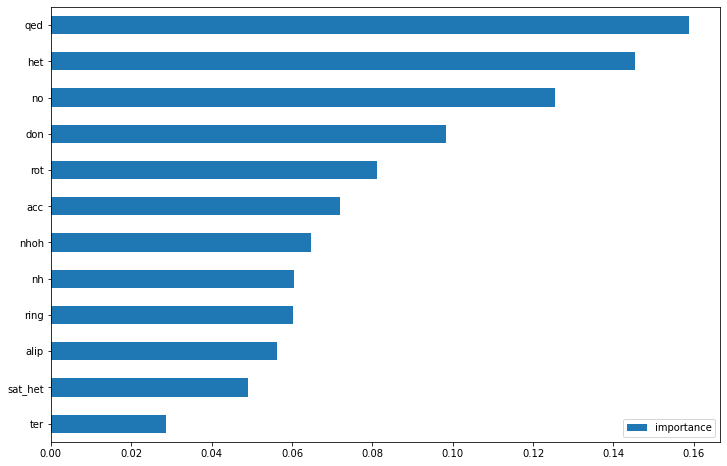

In [ ]:
np.random.seed(7)
imp = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

The most important features are quantitative estimation of drug-likeness, Number of Heteroatoms and Number of Nitrogens and Oxygens

- nh = NHOHCount
- het = NumHeteroatoms
- don = NumHDonors
- nhoh = NHOHCount
- acc = NumHAcceptors
- sat_het = NumSaturatedHeterocycles
- ter = fr_Al_OH_noTert
- alip = NumAliphaticHeterocycles
- no = NOCount
- qed = QED
- rot = NumRotatableBonds
- ring = RingCount

# GNN model

Is a definitely more complex model (which actually guaranties nothing)

In [ ]:
import torch.nn.functional as F

from copy import deepcopy
from hyperopt import hp, fmin, tpe
from shutil import copyfile

In [ ]:
!pip install dgl

     |████████████████████████████████| 4.4 MB 12.3 MB/s 


In [ ]:
!pip install dgllife

     |████████████████████████████████| 138 kB 13.2 MB/s 
  Created wheel for dgllife: filename=dgllife-0.2.9-py3-none-any.whl size=219056 sha256=a70f9aecbc584d2d32e4d1b55196c191987b7dd0f9b7f5e3936e8f7e20ce0837
  Stored in directory: /root/.cache/pip/wheels/34/83/11/9772c74b559d9182c9083362e8ba8b0201c4963e41e03859fe
Successfully built dgllife


Here we use:
- scaffold split (again)
- GraphConv featurization

Default config + dataset w/o augmentation:

Best val roc_auc: 0.9716 +- 0.0010

Test roc_auc: 0.6645 +- 0.0245

In [ ]:
tasks, all_dataset, transformers = load_bbbp(featurizer=dc.feat.MolGraphConvFeaturizer(), splitter='scaffold', reload=False)

Failed to featurize datapoint 59, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 61, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 391, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 614, None. Appending empty array
Exception messa

* not a good thing to re-split the data over and over again, but the previous split was lost

In [ ]:
all_dataset

(<DiskDataset X.shape: (1631,), y.shape: (1631, 1), w.shape: (1631, 1), task_names: ['p_np']>,
 <DiskDataset X.shape: (204,), y.shape: (204, 1), w.shape: (204, 1), ids: ['[H+].C2=C1C(OC(=NC1=CC=C2Cl)NCC)(C3=CC=CC=C3)C.[Cl-]'
  'C1=CC=CC2=C1C(C3=C(N(C)C2=O)C=CC=C3)OCC'
  'C1=C(Cl)C=CC3=C1C(C2=CC=CC=C2)SC(=N3)NCC' ...
  'CC1(C)S[C@@H]2[C@H](NC(=O)C34C[C@H]5C[C@H](CC(N)(C5)C3)C4)C(=O)N2[C@H]1C(O)=O'
  'COc1cccc2C(=O)c3c(O)c4CC(O)(CC(O)c4c(O)c3C(=O)c12)C(=O)CO'
  'CC[C@@]1(O)C[C@H](OC2CC(C(OC3CC(O)C(OC4CCC(=O)C(C)O4)C(C)O3)C(C)O2)N(C)C)c5c(O)c6C(=O)c7c(O)cccc7C(=O)c6cc5[C@H]1C(=O)OC'], task_names: ['p_np']>,
 <DiskDataset X.shape: (204,), y.shape: (204, 1), w.shape: (204, 1), ids: ['CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N2CCC[C@H]2C(O)=O'
  'FC(F)(F)[C@]1(OC(=O)Nc2ccc(Cl)cc12)C#CC3CC3'
  'CN1C[C@@H](C[C@H]2[C@H]1Cc3c[nH]c4cccc2c34)C(=O)N[C@]5(C)O[C@@]6(O)[C@@H]7CCCN7C(=O)[C@H](Cc8ccccc8)N6C5=O'
  ... 'Cn1c2CCC(Cn3ccnc3C)C(=O)c2c4ccccc14'
  'CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)c4c(O)cccc4[C@@

In [ ]:
all_dataset[0].ids

array(['C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl', 'C[C@H](N)Cc1ccccc1',
       'C[S](=O)(=O)c1ccc(cc1)[C@@H](O)[C@@H](CO)NC(=O)C(Cl)Cl', ...,
       'C1=CC=CC2=C1C3=C(C(=O)N2CCCN(C)C)C=CC=C3',
       'C3=C(C2(OC(C1CCCCN1)CO2)CC)C=CC=C3',
       'C1=C(C=CC=C1N3CCN(CCCN2C(N(C(=N2)CC)CC)=O)CC3)Cl'], dtype=object)

In [ ]:
train_df = pd.DataFrame({'smiles': all_dataset[0].ids, 'p_np': [item for sublist in all_dataset[0].y.tolist() for item in sublist]} , columns=["smiles", 'p_np'])
train_df.to_csv("train_2.csv")

In [ ]:
train_aug = augmentation(train_df, [10,50])

In [ ]:
train_aug.shape

(27071, 2)

In [ ]:
print('Train_aug Samples:', train_aug.shape[0])
print('Positive:Negative',np.sum(train_aug.p_np == 1)/ np.sum(train_aug.p_np == 0))

Train_aug Samples: 27071
Positive:Negative 1.0317472230561393


Now classes are equal

In [ ]:
train_aug.to_csv('aug_2.csv', index=False)

In [ ]:
dataset_file = os.path.join('/content/', 'aug_2.csv')
loader = dc.data.CSVLoader(tasks=['p_np'], feature_field="smiles", featurizer= dc.feat.MolGraphConvFeaturizer())
train_set = loader.create_dataset(dataset_file)

In [ ]:
def load_model(save_pth, args, tasks, hyperparams):
  mode = 'classification'
  # binary classification
  n_classes = 2
  if args['featurizer'] == 'GC':
    number_atom_features = 30

  if args['model'] == 'GCN':
    model = dc.models.GCNModel(
        n_tasks=len(tasks),
        graph_conv_layers=[hyperparams['hidden_feats']] *
        hyperparams['num_gnn_layers'],
        activation=F.relu,
        residual=hyperparams['residual'],
        batchnorm=hyperparams['batchnorm'],
        dropout=hyperparams['dropout'],
        predictor_hidden_feats=hyperparams['hidden_feats'],
        predictor_dropout=hyperparams['dropout'],
        mode=mode,
        number_atom_features=number_atom_features,
        n_classes=n_classes,
        learning_rate=hyperparams['lr'],
        model_dir=save_pth)
  else:
    raise ValueError('Unexpected model: {}'.format(args['model']))

  return model


def main(train_set, val_set, test_set, save_path, args, hyperparams):
  # Dataset
  #args, tasks, all_dataset, transformers = load_dataset(args)
  #train_set, val_set, test_set = all_dataset

  # Metric

  metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

  all_run_val_metrics = []
  all_run_test_metrics = []

  for _ in range(args['num_runs']):
    # Model
    model = load_model(save_path, args, tasks, hyperparams)
    # Object for early stop tracking
    stopper = EarlyStopper(save_path, args['metric'], args['patience'])

    # 1000 for maximum number of epochs
    for epoch in range(100):
      model.fit(
          train_set,
          nb_epoch=1,
          max_checkpoints_to_keep=1,
          deterministic=False,
          restore=epoch > 0)

      val_metric = model.evaluate(val_set, [metric], transformers)
      if args['metric'] == 'roc_auc':
        val_metric = val_metric['mean-roc_auc_score']
      if args['metric'] == 'rmse':
        val_metric = val_metric['mean-rms_score']

      # Early stop
      to_stop = stopper(model, val_metric)
      if to_stop:
        break

    stopper.load_state_dict(model)
    val_metric = model.evaluate(val_set, [metric], transformers)
    test_metric = model.evaluate(test_set, [metric], transformers)

    if args['metric'] == 'roc_auc':
      val_metric = val_metric['mean-roc_auc_score']
      test_metric = test_metric['mean-roc_auc_score']
    elif args['metric'] == 'rmse':
      val_metric = val_metric['mean-rms_score']
      test_metric = test_metric['mean-rms_score']

    all_run_val_metrics.append(val_metric)
    all_run_test_metrics.append(test_metric)

  with open(save_path + '/eval.txt', 'w') as f:
    f.write('Best val {}: {:.4f} +- {:.4f}\n'.format(
        args['metric'], np.mean(all_run_val_metrics),
        np.std(all_run_val_metrics)))
    f.write('Test {}: {:.4f} +- {:.4f}\n'.format(args['metric'],
                                                 np.mean(all_run_test_metrics),
                                                 np.std(all_run_test_metrics)))

  with open(save_path + '/configure.json', 'w') as f:
    json.dump(hyperparams, f, indent=2)

  return all_run_val_metrics, all_run_test_metrics


def init_hyper_search_space(args):
  # Model-based search space
  if args['model'] == 'GCN':
    search_space = {
        'lr': hp.uniform('lr', low=1e-4, high=3e-1),
        'hidden_feats': hp.choice('hidden_feats', [32, 64, 128, 256, 512]),
        'num_gnn_layers': hp.choice('num_gnn_layers', [1, 2, 3, 4, 5]),
        'residual': hp.choice('residual', [True, False]),
        'batchnorm': hp.choice('batchnorm', [True, False]),
        'dropout': hp.uniform('dropout', low=0., high=0.6)
    }
  else:
    raise ValueError('Unexpected model: {}'.format(args['model']))

  return search_space


def bayesian_optimization(args, train_set, val_set, test_set):
  results = []
  candidate_hypers = init_hyper_search_space(args)

  def objective(hyperparams):
    configure = deepcopy(args)
    save_path = init_trial_path(args)
    val_metrics, test_metrics = main(train_set, val_set, test_set, save_path, configure, hyperparams)

    if args['metric'] in ['roc_auc']:
      # To maximize a non-negative value is equivalent to minimize its opposite number
      val_metric_to_minimize = -1 * np.mean(val_metrics)
    else:
      val_metric_to_minimize = np.mean(val_metrics)

    results.append((save_path, val_metric_to_minimize, val_metrics,
                    test_metrics))

    return val_metric_to_minimize

  fmin(
      objective,
      candidate_hypers,
      algo=tpe.suggest,
      max_evals=args['num_trials'])
  results.sort(key=lambda tup: tup[1])
  best_trial_path, _, best_val_metrics, best_test_metrics = results[0]

  copyfile(best_trial_path + '/configure.json',
           args['result_path'] + '/configure.json')
  copyfile(best_trial_path + '/eval.txt', args['result_path'] + '/eval.txt')

  return best_val_metrics, best_test_metrics

In [ ]:
args= {'dataset' : 'BBBP',
  'model' : 'GCN',
  'featurizer' : 'GC',
  'result_path' : 'resultsnew',
  'num_runs' : 3,
  'patience' : 30,
  'hyper_search' : False,  # hyper search on augmented data is too long, so I did it on initial data and saved config
  'num_trials' : 16}

In [ ]:
args['metric'] = 'roc_auc'
val_set= all_dataset[1]
test_set = all_dataset[2]
mkdir_p(args['result_path'])
##########################################
if args['hyper_search']:
  print('Start hyperparameter search with Bayesian '
        'optimization for {:d} trials'.format(args['num_trials']))
  val_metrics, test_metrics = bayesian_optimization(args, train_set, val_set, test_set)
else:
  print('Use the manually specified hyperparameters')
  with open('BBB.json') as f:
    default_hyperparams = json.load(f)
  val_metrics, test_metrics = main(train_set, val_set, test_set, args['result_path'], args,
                                    default_hyperparams)
  print('Val metric for 3 runs: {:.4f} +- {:.4f}'.format(np.mean(val_metrics), np.std(val_metrics)))
  print('Test metric for 3 runs: {:.4f} +- {:.4f}'.format(np.mean(test_metrics), np.std(test_metrics)))

Created directory resultsnew
Use the manually specified hyperparameters


/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr

Val metric for 3 runs: 0.9631 +- 0.0083
Test metric for 3 runs: 0.6812 +- 0.0226


Resulting score is:

Best val roc_auc: 0.9631 +- 0.0083

Test roc_auc: 0.6812 +- 0.0226

(This is a higher score, but still not so good as for RF)

Conclusions:
- RF model shows better results than GNN
- in our case simplier model performs better
- augmentation helps to increase the score for both models
